# Classify pulled tweets from twitter, for major US airlines.

In [1]:
cd '/home/jovyan/GA_DSI/Projects/capstone'

/home/jovyan/GA_DSI/Projects/capstone


In [24]:
#!pip install gensim

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import gensim
import re
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import lib.general_utilities as gu

from IPython.display import display
from IPython.display import Image
from sys import getsizeof
import matplotlib.pyplot as plt

processed_dir = 'data/processed_dataset_df/'

%matplotlib inline


### NOTE: Tweets were pulled using filtering by #airlinename.

## Process pulled tweets by cleaning, removing stop words and lemmatizing.

In [102]:
# exclude name of airlines from the tweets. 
exclude = ['unitedairlines', 'americanairlines', 'southwestairlines',
           'virginamerica', 'usairways', 'jetblue', 'delta', 'flight', 'flights',
           'amp', 'amp;']

# load stopwords and exclude punctuation sets.
stop_words = list(ENGLISH_STOP_WORDS) + exclude
exclude_punctuation = set(string.punctuation) 
lemma = WordNetLemmatizer()

In [49]:
def tokenize(text):
    return(text.split())

In [50]:
def cleaner(text):
    # convert text to lowercase.
    text = text.lower()
    # remove www.* or https?://* to URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
    # remove @username to AT_USER
    text = re.sub('@[^\s]+','',text)
    # remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    # Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)
    # remove some punctuation symbols.
    text= ''.join(ch for ch in text if ch not in exclude_punctuation)
    # clean numbers.
    text = re.sub('&#39;','',text).lower()
    # trim
    text = text.strip('\'"')
    # trim any leading or trailing white spaces.
    text = text.strip()

    return(text)

In [99]:
# remove stopwords.
def remove_stopwords(text):
    '''
    remove english stop words
    '''
    token_text = tokenize(text)
    text = ' '.join(i for i in token_text if (i.strip() not in stop_words))
    return(text)

In [96]:
def lemmatize(text):
    
    # lemmatize: replace word with root of the word.
    text = ' '.join(lemma.lemmatize(word) for word in text.split())
    
    return(text)

In [52]:
#!pip install emoji

In [53]:
import emoji

In [54]:
# read in pickled emoji dictionary I created from emojis in the dataset. I want to use
# each emoji as an individual feature.
file = 'data/pickled/Emoticon_NB4/full_emoji_dict.obj'
emoji_dict = gu.read_pickle_obj(file)

In [55]:
def encode_emojis(text):
    input_txt = text
    for em in text:
        if em in emoji.UNICODE_EMOJI:
            try:
                input_txt = input_txt.replace(em, emoji_dict[em])
            except:
                # update dict.
                cnt = len(emoji_dict.keys())
                cnt+=1
                val='EMOJI_'+str(cnt)
                emoji_dict[em]=val
                input_txt = input_txt.replace(em, val)
                
    return(input_txt)

In [56]:
def extract_emojis(text):
    return(' '.join(word for word in text if word in emoji.UNICODE_EMOJI))

In [57]:
def declump_emojis_in_text(text):
    em_txt = text        
    for i in text:
        if (i in emoji.UNICODE_EMOJI):
            em_txt = em_txt.replace(i,' '+i)
        
    return(em_txt)

In [107]:
# Read in pulled tweets dataframe.
filename = 'data/pulled_tweets/PT_all_airlines_df'
pulledTweets_df = gu.read_pickle_obj(filename)

# Drop duplicate rows if any.
pulledTweets_df.drop_duplicates(subset='text', inplace=True)

pulledTweets_df.head(3)

,airline,date,text
0,UnitedAirlines,2018-01-09 21:19:36,Kudos to the #unitedairlines staff for helping...
1,UnitedAirlines,2018-01-09 21:06:39,And the painful experience with @united conti...
2,UnitedAirlines,2018-01-09 21:02:07,@united is the shittiest airline company I hav...


In [108]:
pulledTweets_df.columns

Index(['airline', 'date', 'text'], dtype='object')

In [109]:
# Process data using Natural Language Processing techniques: clean, remove stop words and lemmatize.
pulledTweets_df['Processed_tweet'] = pulledTweets_df['text'].apply(cleaner)
pulledTweets_df['Processed_tweet'] = pulledTweets_df['Processed_tweet'].apply(remove_stopwords)
pulledTweets_df['Processed_tweet'] = pulledTweets_df['Processed_tweet'].apply(lemmatize)

In [110]:
pulledTweets_df.head(20)

,airline,date,text,Processed_tweet
0,UnitedAirlines,2018-01-09 21:19:36,Kudos to the #unitedairlines staff for helping...,kudos staff helping crazy reservation nice sen...
1,UnitedAirlines,2018-01-09 21:06:39,And the painful experience with @united conti...,painful experience continues ask time lengthy ...
2,UnitedAirlines,2018-01-09 21:02:07,@united is the shittiest airline company I hav...,shittiest airline company experienced fuck nev...
3,UnitedAirlines,2018-01-09 20:56:00,Oh joy. You came home. #lostluggage #unitedair...,oh joy came home lostluggage
4,UnitedAirlines,2018-01-09 20:49:48,RT @officiParas: #UnitedAirlines Offers Custom...,rt offer customer free checked bag travel tofr...
5,UnitedAirlines,2018-01-09 20:41:02,#UnitedAirlines - still can’t understand why a...,can’t understand 1 million miler 2mm board grp...
6,UnitedAirlines,2018-01-09 20:33:20,My knees #unitedAIRLINES https://t.co/qErdox2Cht,knee
7,UnitedAirlines,2018-01-09 20:24:22,@theweeknd cuts ties with H&amp;M over 'monkey...,cut tie hampm monkey ad blm equality4all monke...
8,UnitedAirlines,2018-01-09 20:15:15,"A peek inside Classified, where CEOs and celeb...",peek inside classified ceo celebrity dine hidd...
9,UnitedAirlines,2018-01-09 19:48:04,"Montreal, Canada to Phoenix, Arizona for only ...",montreal canada phoenix arizona 271 cad roundt...


In [111]:
# right now ☺️👍 will be a feature. I want features independent 
# as ☺️ and 👍. Let's declump them.

pulledTweets_df['emoji_enc_text'] = pulledTweets_df['Processed_tweet'].apply(declump_emojis_in_text)
# Now let's encode the emojis so we can use it in the vectorizer as a feature.
pulledTweets_df['emoji_enc_text'] = pulledTweets_df['emoji_enc_text'].apply(encode_emojis)

# create a new category 'emojis' with extracted emojis from tweets.
pulledTweets_df['emojis'] = pulledTweets_df['Processed_tweet'].apply(extract_emojis)

In [112]:
pulledTweets_df.head(20)

,airline,date,text,Processed_tweet,emoji_enc_text,emojis
0,UnitedAirlines,2018-01-09 21:19:36,Kudos to the #unitedairlines staff for helping...,kudos staff helping crazy reservation nice sen...,kudos staff helping crazy reservation nice sen...,
1,UnitedAirlines,2018-01-09 21:06:39,And the painful experience with @united conti...,painful experience continues ask time lengthy ...,painful experience continues ask time lengthy ...,
2,UnitedAirlines,2018-01-09 21:02:07,@united is the shittiest airline company I hav...,shittiest airline company experienced fuck nev...,shittiest airline company experienced fuck nev...,
3,UnitedAirlines,2018-01-09 20:56:00,Oh joy. You came home. #lostluggage #unitedair...,oh joy came home lostluggage,oh joy came home lostluggage,
4,UnitedAirlines,2018-01-09 20:49:48,RT @officiParas: #UnitedAirlines Offers Custom...,rt offer customer free checked bag travel tofr...,rt offer customer free checked bag travel tofr...,
5,UnitedAirlines,2018-01-09 20:41:02,#UnitedAirlines - still can’t understand why a...,can’t understand 1 million miler 2mm board grp...,can’t understand 1 million miler 2mm board grp...,
6,UnitedAirlines,2018-01-09 20:33:20,My knees #unitedAIRLINES https://t.co/qErdox2Cht,knee,knee,
7,UnitedAirlines,2018-01-09 20:24:22,@theweeknd cuts ties with H&amp;M over 'monkey...,cut tie hampm monkey ad blm equality4all monke...,cut tie hampm monkey ad blm equality4all monke...,
8,UnitedAirlines,2018-01-09 20:15:15,"A peek inside Classified, where CEOs and celeb...",peek inside classified ceo celebrity dine hidd...,peek inside classified ceo celebrity dine hidd...,
9,UnitedAirlines,2018-01-09 19:48:04,"Montreal, Canada to Phoenix, Arizona for only ...",montreal canada phoenix arizona 271 cad roundt...,montreal canada phoenix arizona 271 cad roundt...,


In [113]:
for row in range(100,106):
    print('Tweet: ')
    # Some tweets have \n - newlines, remove so it displays well.
    text = pulledTweets_df.text[pulledTweets_df.emojis!=''].values[row]
    text = text.replace('\n','')
    print('RAW TWEET: ', text, '\n')
    print('PROCESSED TWEET: ', pulledTweets_df.Processed_tweet[pulledTweets_df.emojis!=''].values[row], '\n')
    print('EMOJI ENC TWEET: ', pulledTweets_df.emoji_enc_text[pulledTweets_df.emojis!=''].values[row], '\n\n')

Tweet: 
RAW TWEET:  From https://t.co/vIwrgN5xSaReady to go.. ✈️😍💯 #AmericanAirlines #Thenewamerican #B737 #intheair #americanflight #aa #flights #saturday #intapic #instaimag #photooftheday #likes #zoom #crew #pilots #crewamerican #honduras #hn #aiport #iphonecamera #newphoto #inlove #newcap… https://t.co/BhaD0tVyKC 

PROCESSED TWEET:  ready ✈️😍💯 thenewamerican b737 intheair americanflight aa saturday intapic instaimag photooftheday like zoom crew pilot crewamerican honduras hn aiport iphonecamera newphoto inlove newcap… 

EMOJI ENC TWEET:  ready  EMOJI_7️ EMOJI_11 EMOJI_90 thenewamerican b737 intheair americanflight aa saturday intapic instaimag photooftheday like zoom crew pilot crewamerican honduras hn aiport iphonecamera newphoto inlove newcap… 


Tweet: 
RAW TWEET:  #AmericanAirlines  you have really dropped the ball with flight 997. You have known it was delayed since 6 yet you didn’t bother the get a backup crew here! You have a lot of unhappy customers! 😡 

PROCESSED TWEET:  r

## Pickle processed pulled tweets.

In [115]:
# Update emoji dict. Eventually unicode-escape this.
file = 'data/pickled/Emoticon_NB4/full_emoji_dict.obj'
gu.pickle_obj(file, emoji_dict)

In [116]:
# pickle pulled data.
filename = processed_dir+'pulledTweetsCleanedLemmaEmEnc_df'
gu.pickle_obj(filename,pulledTweets_df)

## Use best grid searched Naive Bayes and Logistic Regression models to classify tweets.

In [118]:
EmEnc_model_results_gs_df[EmEnc_model_results_gs_df.dataset=='lemmatized']

,dataset,model,tr_acc_score,tst_acc_score,pipe_object,y_pred,ytest,ypred_proba
6,lemmatized,NaiveBayes,0.902020,0.850046,"GridSearchCV(cv=5, error_score='raise',\n ...","[1, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.0691840852212, 0.774504066889, 0.156311847..."
7,lemmatized,LogisticRegression,0.936731,0.864438,"GridSearchCV(cv=5, error_score='raise',\n ...","[1, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.180051121496, 0.759980075461, 0.0599688030..."


### Use best models found for lemmatized data.

In [119]:
pipe_nb  =EmEnc_model_results_gs_df.get_value(6, 'pipe_object')
pipe_lr = EmEnc_model_results_gs_df.get_value(7, 'pipe_object')

# pickle models.
file1 = processed_dir+'pipe_nb_lemma.obj'
file2 = processed_dir+'pipe_lr_lemma.obj'
gu.pickle_obj(file1, pipe_nb)
gu.pickle_obj(file2, pipe_lr)

In [120]:
pipe_nb.best_params_, pipe_lr.best_params_

({'model__alpha': 0.10000000000000001,
  'vec__max_df': 0.95,
  'vec__min_df': 5,
  'vec__ngram_range': (1, 2)},
 {'model__C': 1.0,
  'vec__max_df': 0.95,
  'vec__min_df': 5,
  'vec__ngram_range': (1, 2)})

In [122]:
classes = {0:'negative', 1:'neutral', 2:'positive'}

In [123]:
# Naive Bayes
y_pred = pipe_nb.predict(pulledTweets_df.emoji_enc_text)
y_proba = pipe_nb.predict_proba(pulledTweets_df.emoji_enc_text)

pulledTweets_df['sentiment_predicted_nb']=[classes[y_pred[i]] for i in range(len(y_pred))]

In [125]:
# Logistic Regression.
y_pred = pipe_lr.predict(pulledTweets_df.emoji_enc_text)
y_proba = pipe_lr.predict_proba(pulledTweets_df.emoji_enc_text)

pulledTweets_df['sentiment_predicted_lr']=[classes[y_pred[i]] for i in range(len(y_pred))]

In [127]:
pulledTweets_df[['text', 'sentiment_predicted_nb', 'sentiment_predicted_lr', 'emojis']][:20]

,text,sentiment_predicted_nb,sentiment_predicted_lr,emojis
0,Kudos to the #unitedairlines staff for helping...,positive,positive,
1,And the painful experience with @united conti...,negative,negative,
2,@united is the shittiest airline company I hav...,negative,negative,
3,Oh joy. You came home. #lostluggage #unitedair...,negative,negative,
4,RT @officiParas: #UnitedAirlines Offers Custom...,neutral,negative,
5,#UnitedAirlines - still can’t understand why a...,negative,negative,
6,My knees #unitedAIRLINES https://t.co/qErdox2Cht,negative,neutral,
7,@theweeknd cuts ties with H&amp;M over 'monkey...,negative,negative,
8,"A peek inside Classified, where CEOs and celeb...",neutral,neutral,
9,"Montreal, Canada to Phoenix, Arizona for only ...",negative,neutral,


### Pickle dataframe with processed and classified tweets.

In [129]:
# pickle classified data.
filename = processed_dir+'pulledTweetsProcessedAndClassified_df'
gu.pickle_obj(filename,pulledTweets_df)

In [3]:
# read pickled data.
pulledTweets_df = gu.read_pickle_obj(processed_dir+'pulledTweetsProcessedAndClassified_df')

In [5]:
pulledTweets_df.head(2)

,airline,date,text,Processed_tweet,emoji_enc_text,emojis,sentiment_predicted_nb,sentiment_predicted_lr
0,UnitedAirlines,2018-01-09 21:19:36,Kudos to the #unitedairlines staff for helping...,kudos staff helping crazy reservation nice sen...,kudos staff helping crazy reservation nice sen...,,positive,positive
1,UnitedAirlines,2018-01-09 21:06:39,And the painful experience with @united conti...,painful experience continues ask time lengthy ...,painful experience continues ask time lengthy ...,,negative,negative


### Let's visualize the predictions for both models.

In [6]:
df = pulledTweets_df[pulledTweets_df.airline != 'USAirways']

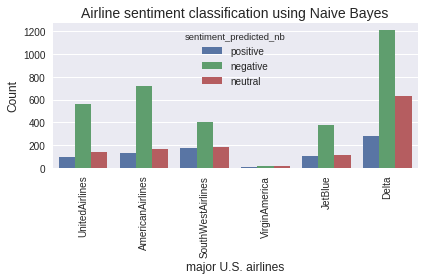

In [13]:
# Airline sentiment using Naive Bayes.
sns.countplot(x="airline", hue="sentiment_predicted_nb", data = df)
plt.title('Airline sentiment classification using Naive Bayes',
         fontsize=14)
plt.xlabel('major U.S. airlines', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('data/images/Pulled_Tweets/'+'NB_sentiment_classification_hist.png')

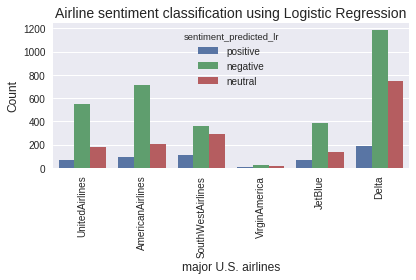

In [11]:
# Airline sentiment using Logistic Regression.
sns.countplot(x="airline", hue="sentiment_predicted_lr", data=df)
plt.title('Airline sentiment classification using Logistic Regression',
         fontsize=14)
plt.xlabel('major U.S. airlines', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('data/images/Pulled_Tweets/'+'LR_sentiment_classification_hist.png')

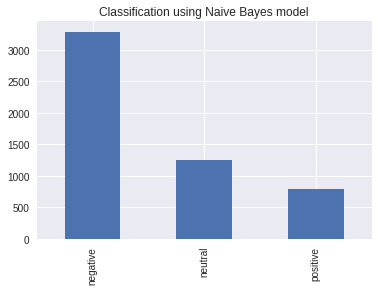

In [153]:
# look at the count of values for the 3 categories.
pulledTweets_df.sentiment_predicted_nb.value_counts().plot(kind='bar', 
                                                           title = 'Classification using Naive Bayes model')
plt.savefig('data/images/Pulled_Tweets/'+'NB_class_hist.png')

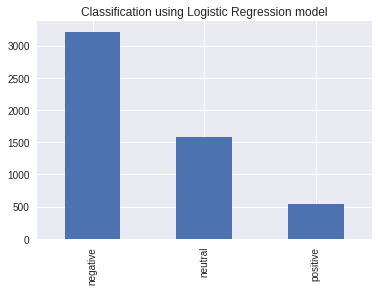

In [154]:
# look at the count of values for the 3 categories.
pulledTweets_df.sentiment_predicted_lr.value_counts().plot(kind='bar', 
                                                           title = 'Classification using Logistic Regression model')
plt.savefig('data/images/Pulled_Tweets/'+'LR_class_hist.png')

In [139]:
for i in range(50):
    print('TWEET:\n', pulledTweets_df.date.values[i], '\n', pulledTweets_df.text.values[i], 
          '\n\nSentiment Prediction NB:\n', pulledTweets_df.sentiment_predicted_nb.values[i],
          '\nSentiment Prediction LR:\n', pulledTweets_df.sentiment_predicted_lr.values[i],
          '\n')

TWEET:
 2018-01-09T21:19:36.000000000 
 Kudos to the #unitedairlines staff for helping us with our crazy reservations.  Nice send-off from CHS 

Sentiment Prediction NB:
 positive 
Sentiment Prediction LR:
 positive 

TWEET:
 2018-01-09T21:06:39.000000000 
 And the painful experience with  @united continues as they ask us to take the time to fill out lengthy reports on their website and to relive the blissful experience again. Thanks for nothing #unitedairlines ! https://t.co/W9skVmOhZw 

Sentiment Prediction NB:
 negative 
Sentiment Prediction LR:
 negative 

TWEET:
 2018-01-09T21:02:07.000000000 
 @united is the shittiest airline company I have ever experienced. Fuck #UnitedAirlines #neveragain #lieslieslies 

Sentiment Prediction NB:
 negative 
Sentiment Prediction LR:
 negative 

TWEET:
 2018-01-09T20:56:00.000000000 
 Oh joy. You came home. #lostluggage #unitedairlines https://t.co/msJgTAjiz6 https://t.co/8fHuZntw7e 

Sentiment Prediction NB:
 negative 
Sentiment Prediction LR:
 n

## Observations: 
Text classification can be very challenging, due to high levels of ambiguity.<br>
Then add to that the erratic language used by tweeters and that just makes it harder.<br>
Then the issue of training data to train a model arises. Most often we have data with no labels, which makes supervised learning for this kind of data challenging.

This leads to my next exploration... unsupervised learning - Topic Modelling using LDA model.

## [Next Notebook: LDA Topic Modeling](4_TechnicalP_LDA.ipynb) 